In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
dataset = pd.read_csv("MH_precrocessed_dataset.csv")

In [3]:
# EDA dan sonra bazı columnları attım çünkü corr matrixi inceledim ve kategorik değerlerin price ile karşılaştırması sonrası gereksiz gördüğümden dolayı:
# Address = Her satıra özel, yüksek kardinaliteli ve tahmin gücü olmayan gürültülü veri
# SellerG = Satıcı adı değişkendir, gelecek tahminlerde tutarsızlığa yol açabilir
# Date = Satış zamanı fiyatla doğrudan ilişkili görünmüyor (gürültü)
# Propertycount = Bölgedeki ilan sayısı, fiyatla doğrudan anlamlı bir korelasyon göstermedi
# Postcode = Fiyat üzerinde çok az etkisi var, ayrıca CouncilArea gibi alternatif sütunlar var
dataset_after_eda = dataset.drop(columns=["Address", "SellerG", "Date", "Propertycount", "Postcode"])

In [4]:
dataset_after_eda.head()

,Suburb,Rooms,Type,Price,Method,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname
0,Hillside,3,h,781500,S,18.0,3,2,2,666,139,1970,Brimbank City Council,-37.70161,144.753300,Western Metropolitan
1,Brighton East,3,h,1056532,S,10.7,3,2,2,196,115,2009,Bayside City Council,-37.93020,145.029000,Southern Metropolitan
2,Glen Iris,4,h,1997500,S,7.3,4,2,2,621,216,1945,Boroondara City Council,-37.86544,145.067390,Southern Metropolitan
3,Oak Park,3,u,600000,SP,11.5,3,1,2,581,139,1970,Moreland City Council,-37.71667,144.913682,Northern Metropolitan
4,Beaumaris,4,h,1140000,S,17.3,4,2,2,790,171,1995,Bayside City Council,-37.97501,145.052570,Southern Metropolitan


In [5]:
dataset_after_eda.dtypes

Suburb           object
Rooms             int64
Type             object
Price             int64
Method           object
Distance        float64
Bedroom2          int64
Bathroom          int64
Car               int64
Landsize          int64
BuildingArea      int64
YearBuilt         int64
CouncilArea      object
Lattitude       float64
Longtitude      float64
Regionname       object
dtype: object

<Axes: xlabel='Price', ylabel='Count'>

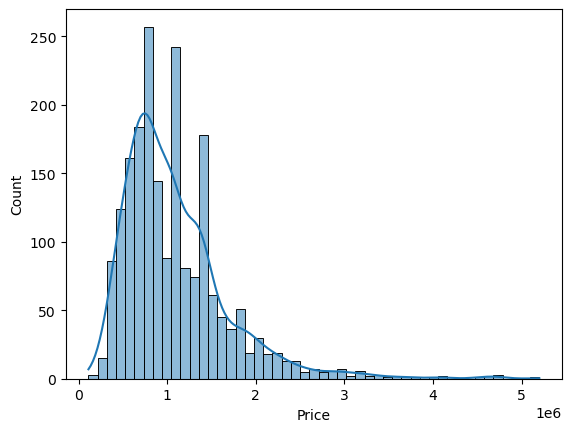

In [6]:
sns.histplot(dataset_after_eda["Price"], kde=True)

<Axes: xlabel='Price', ylabel='Count'>

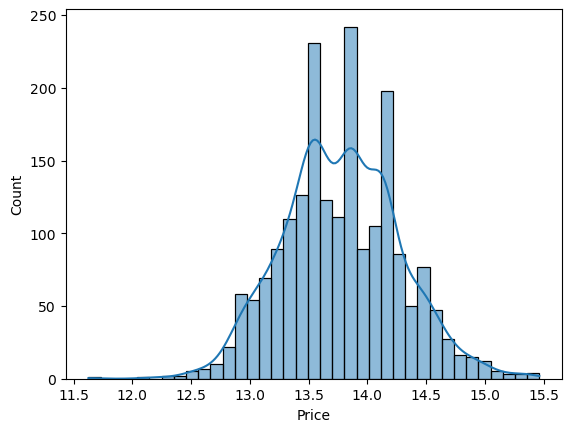

In [7]:
# normalize edilmiş hali
sns.histplot(np.log1p(dataset_after_eda["Price"]), kde=True)

Regression

In [8]:
# price a göre regressyon yapacağım
# price distribution tablosu right skewed olduğu için log(1+x) formülüyle log dönüşüm yapıp fiyatlar arasındaki farkı azalttım
y = np.log1p(dataset_after_eda["Price"])
X = dataset_after_eda.drop(columns=["Price"])

In [9]:
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# numerik kategorik değerleri (Rooms, Car, Bedroom2, Bathroom) numerical_cols dan ayırıyorum
numerical_cols = [col for col in numerical_cols if col not in ['Rooms', 'Car', 'Bedroom2', 'Bathroom']]
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
# numerik kategorik değerleri (Rooms, Car, Bedroom2, Bathroom) categorical_cols a ekliyorum
categorical_cols.extend(['Rooms', 'Car', 'Bedroom2', 'Bathroom'])

In [10]:
numerical_cols

['Distance',
 'Landsize',
 'BuildingArea',
 'YearBuilt',
 'Lattitude',
 'Longtitude']

In [11]:
categorical_cols

['Suburb',
 'Type',
 'Method',
 'CouncilArea',
 'Regionname',
 'Rooms',
 'Car',
 'Bedroom2',
 'Bathroom']

In [12]:
# verisetimin kopyasını oluşturuyorum
X_scaled = X.copy()

In [13]:
# numerical değerlere standard scaler uyguluyorum
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled[numerical_cols] = scaler.fit_transform(X_scaled[numerical_cols])
X_scaled.head()

,Suburb,Rooms,Type,Method,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname
0,Hillside,3,h,S,1.004945,3,2,2,0.027141,-0.178461,0.074940,Brimbank City Council,1.251663,-2.087638,Western Metropolitan
1,Brighton East,3,h,S,-0.081595,3,2,2,-0.254946,-0.451312,1.644145,Bayside City Council,-1.366516,0.224529,Southern Metropolitan
2,Glen Iris,4,h,S,-0.587654,4,2,2,0.000133,0.696935,-0.930961,Boroondara City Council,-0.624781,0.546488,Southern Metropolitan
3,Oak Park,3,u,SP,0.037478,3,1,2,-0.023875,-0.178461,0.074940,Moreland City Council,1.079172,-0.742592,Northern Metropolitan
4,Beaumaris,4,h,S,0.900756,4,2,2,0.101564,0.185340,1.080841,Bayside City Council,-1.879752,0.422199,Southern Metropolitan


In [14]:
# categorik değerlere one hot encoding uyguluyorum sonra bool değerlerini int çeviriyorum
X_scaled_encoded = pd.get_dummies(X_scaled, columns=categorical_cols, drop_first=True)
bool_cols = X_scaled_encoded.select_dtypes(include=['bool']).columns
X_scaled_encoded[bool_cols] = X_scaled_encoded[bool_cols].astype(int)
X_scaled_encoded.head()

,Distance,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,...,Bedroom2_9,Bedroom2_30,Bathroom_1,Bathroom_2,Bathroom_3,Bathroom_4,Bathroom_5,Bathroom_6,Bathroom_7,Bathroom_12
0,1.004945,0.027141,-0.178461,0.074940,1.251663,-2.087638,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,-0.081595,-0.254946,-0.451312,1.644145,-1.366516,0.224529,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,-0.587654,0.000133,0.696935,-0.930961,-0.624781,0.546488,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0.037478,-0.023875,-0.178461,0.074940,1.079172,-0.742592,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0.900756,0.101564,0.185340,1.080841,-1.879752,0.422199,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Model eğitimleri

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled_encoded, y, test_size=0.2, random_state=42)

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [17]:
models = {
    "Linear Regression": LinearRegression(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=15),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42)
}

In [18]:
result = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mean_error = np.abs(y_test - y_pred).mean()

    result[name] = {"MSE": mse, "RMSE": rmse, "R2": r2, "ME": mean_error}

In [19]:
for model, scores in result.items():
    print(f"\nModel: {model}")
    print(f"MSE: {scores['MSE']:.2f}")
    print(f"RMSE: {scores['RMSE']:.2f}")
    print(f"R2 Score: {scores['R2']:.2f}")
    print(f"Mean error Score: {scores['ME']:.2f}")


Model: Linear Regression
MSE: 0.07
RMSE: 0.26
R2 Score: 0.70
Mean error Score: 0.20

Model: K-Nearest Neighbors
MSE: 0.09
RMSE: 0.30
R2 Score: 0.62
Mean error Score: 0.22

Model: Decision Tree
MSE: 0.13
RMSE: 0.36
R2 Score: 0.42
Mean error Score: 0.27

Model: Random Forest
MSE: 0.06
RMSE: 0.25
R2 Score: 0.73
Mean error Score: 0.19


In [20]:
best_n = 0
best_r2 = 0

for n in range(1, 51):
    model = KNeighborsRegressor(n_neighbors=n)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    if (r2 > best_r2):
        best_r2 = r2
        best_n = n
    print(f"For {n} neighbors -> R2 Score: {r2:.2f}")

print(f"\nBest number of neighbors is: {best_n} with R2 Score: {best_r2:.2f}")

For 1 neighbors -> R2 Score: 0.31
For 2 neighbors -> R2 Score: 0.45
For 3 neighbors -> R2 Score: 0.55
For 4 neighbors -> R2 Score: 0.58
For 5 neighbors -> R2 Score: 0.58
For 6 neighbors -> R2 Score: 0.60
For 7 neighbors -> R2 Score: 0.60
For 8 neighbors -> R2 Score: 0.61
For 9 neighbors -> R2 Score: 0.60
For 10 neighbors -> R2 Score: 0.61
For 11 neighbors -> R2 Score: 0.61
For 12 neighbors -> R2 Score: 0.61
For 13 neighbors -> R2 Score: 0.61
For 14 neighbors -> R2 Score: 0.62
For 15 neighbors -> R2 Score: 0.62
For 16 neighbors -> R2 Score: 0.61
For 17 neighbors -> R2 Score: 0.61
For 18 neighbors -> R2 Score: 0.61
For 19 neighbors -> R2 Score: 0.60
For 20 neighbors -> R2 Score: 0.61
For 21 neighbors -> R2 Score: 0.61
For 22 neighbors -> R2 Score: 0.61
For 23 neighbors -> R2 Score: 0.61
For 24 neighbors -> R2 Score: 0.61
For 25 neighbors -> R2 Score: 0.61
For 26 neighbors -> R2 Score: 0.61
For 27 neighbors -> R2 Score: 0.61
For 28 neighbors -> R2 Score: 0.61
For 29 neighbors -> R2 Score: